# Splines

## Imports

In [1]:
%config InlineBackend.figure_format="retina"

In [2]:
from typing import Sequence

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patsy
import pymc3 as pm
from patsy.design_info import DesignMatrix

## Polynomial regression

Linear model can be written as

$$
\mathbb{E}[Y]= \beta_0 + \beta_1 X
$$

which looks like

$$
\mathbb{E}[Y]= \beta_0 + \beta_1 X + \beta_2 X^2 + \cdots + \beta_m X^m
$$

for a **polynomial regression**.
As we increase the order of the polynomial—$m$—we
increase the flexibility of the curve.
Problem is that polynomials act globally—when
we apply a polynomial of degree $m$
we are saying the relationship between the $Y$ and $X$ is of degree $m$
for the entire dataset.

This can lead to curves that are too flexible,
and prone to overfitting.

## Expanding the feature space

Polynomial regression
is a method to **expand the feature space**.
Beyond polynomials,
we can expand features as:

$$
\mathbb{E}[Y]= \beta_0 + \beta_1 B_{1}(X_{1}) + \beta_2 B_{2}(X_{2}) + \cdots + \beta_m B_{m}(X_{m})
$$

where $B_i$ are arbitrary functions—**basis
functions**.

Besides polynomials,
basis functions
can be a power of two,
lograrithms,
square root,
etc.

Can use indicator functions
like $I(c_i \leq x_k < c_j)$
to break up the original $\boldsymbol{X}$ predictor into (non-overlapping) subsets
and then fit the polynomial locally—only
inside these subsets.
This is fitting **piecewise polynomials**.

![piecewise](images/chapter_5/piecewise.png)

In chart above,
blue line is true function we try to approximate.
Black line are piecewise polynomials of order 1–4—respectively.
Dashed verticals are limits of each subdomain.

Same idea can be extended to more than one predictor,
and be combined with an inverse link function $\phi$.
These are known as **Generalized Additive Models (GAM)**.

$$
\mathbb{E}[Y]= \phi \left(\sum_i^p f(X_i)\right)
$$


## Introducing splines

**Splines** are an atttempt to use flexibility of polynomials
but keep them under control.
A spline needs knots
to split the domain of the variable $\boldsymbol{X}$ into contiguous intervals.
For this purpose a spline is a piecewise polynomial constrained to be continuous—
we enforce two contiguous sub-polynomials to meet at the knots.
If sub-polynomials are of degree $n$
we say the spline is of degree $n$.
Sometimes the splines are referred to by their order—$n + 1$.

Sub-polynomials are known as **Basis splines (B-splines)**.
Any spline function of a given degree
can be constructed as a lineare combination of basis splines of that degree.

![splines basis](images/chapter_5/splines_basis.png)

As we increse the B-spline degree,
the domain of the B-spline grows.
For a higher degree spline to make sense
we need to define more knots.
B-splines here are restricted to be non-zero only
instide a given interval.

As the number of knots controlling each B-splines grows with the degree
we are not able to define a B-spline near the boundaries.
We can add knots at the boundaries to make up for this.
So if our knots are $(0,1,2,3,4,5)$
and we want to fit a cubic spline,
we actually use $(0,0,0,0,1,2,3,4,5,5,5,5)$.
We now have the 5 necessary knots—$(0,0,0,0,1)$—to
define the first B-spline
and $(0,0,0,1,2)$ to define the second B-spline.
We pad the boundary knots as many times as the degree of the splint.

![splines weighted](images/chapter_5/splines_weighted.png)

A linear combination of the B-spline
allows for complex fitting.
We choose:

1. The order of the B-splines
2. The number and location of knots
3. The coefficients to weight each B-spline

The wights are sampled,
so you can have multiple possible combinations over the splines.

Cubic is the most commonly use spline.
They are the lowerst order able to generate smooth enough curves
for most common scenarios.

## Building the design matrix using Patsy

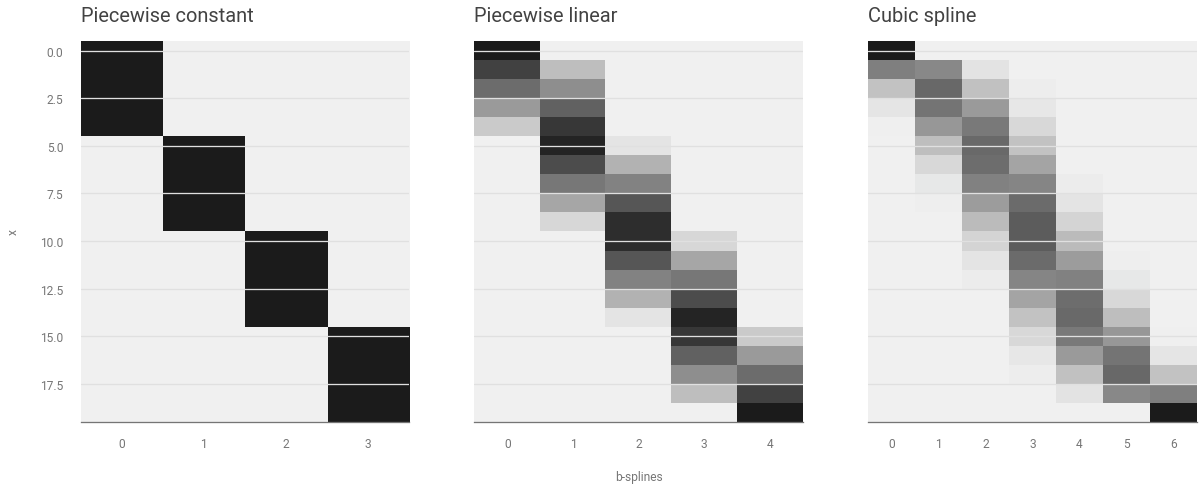

In [43]:
x = np.linspace(0, 1, 20)
knots = [0.25, 0.5, 0.75]


def make_splines(
    x: Sequence[float], knots: Sequence[float], degree: int
) -> DesignMatrix:
    """Create splines using Patsy."""
    splines = patsy.dmatrix(
        f"bs(x, knots=knots, degree={degree}, include_intercept=True) - 1",
        {"x": x, "knots": knots},
    )

    return splines


b0 = make_splines(x, knots=knots, degree=0)
b1 = make_splines(x, knots=knots, degree=1)
b3 = make_splines(x, knots=knots, degree=3)

_, axes = plt.subplots(1, 3, sharey=True, figsize=(20, 7))

for idx, (b, title, ax) in enumerate(
    zip(
        (b0, b1, b3),
        ("Piecewise constant", "Piecewise linear", "Cubic spline"),
        axes,
    )
):
    ax.imshow(b, cmap="cet_gray_r", aspect="auto")
    ax.set_xticks(np.arange(b.shape[1]))
#     ax.set_yticks(np.arange(b.shape[0]))
    ax.set_title(title)

axes[1].set_xlabel("b-splines")
axes[0].set_ylabel("x");

In [28]:
np.asarray(b0)

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [29]:
np.asarray(b1)

array([[1.        , 0.        , 0.        , 0.        , 0.        ],
       [0.99198397, 0.00801603, 0.        , 0.        , 0.        ],
       [0.98396794, 0.01603206, 0.        , 0.        , 0.        ],
       ...,
       [0.        , 0.        , 0.        , 0.01603206, 0.98396794],
       [0.        , 0.        , 0.        , 0.00801603, 0.99198397],
       [0.        , 0.        , 0.        , 0.        , 1.        ]])

In [30]:
np.asarray(b3)

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.76144159e-01, 2.37598421e-02, 9.59129944e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.52670768e-01, 4.69467817e-02, 3.81763335e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.81763335e-04, 4.69467817e-02, 9.52670768e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        9.59129944e-05, 2.37598421e-02, 9.76144159e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

For `b0`
we see the design mattix has only 0s or 1s.
The first B-spline is 1 for the first 5 observations,
and 0 otherwise.
The second B-spline
is 0 for the first 5 observations
1 for the second 5,
and 0 again.

## Fitting splines in  PyMC3

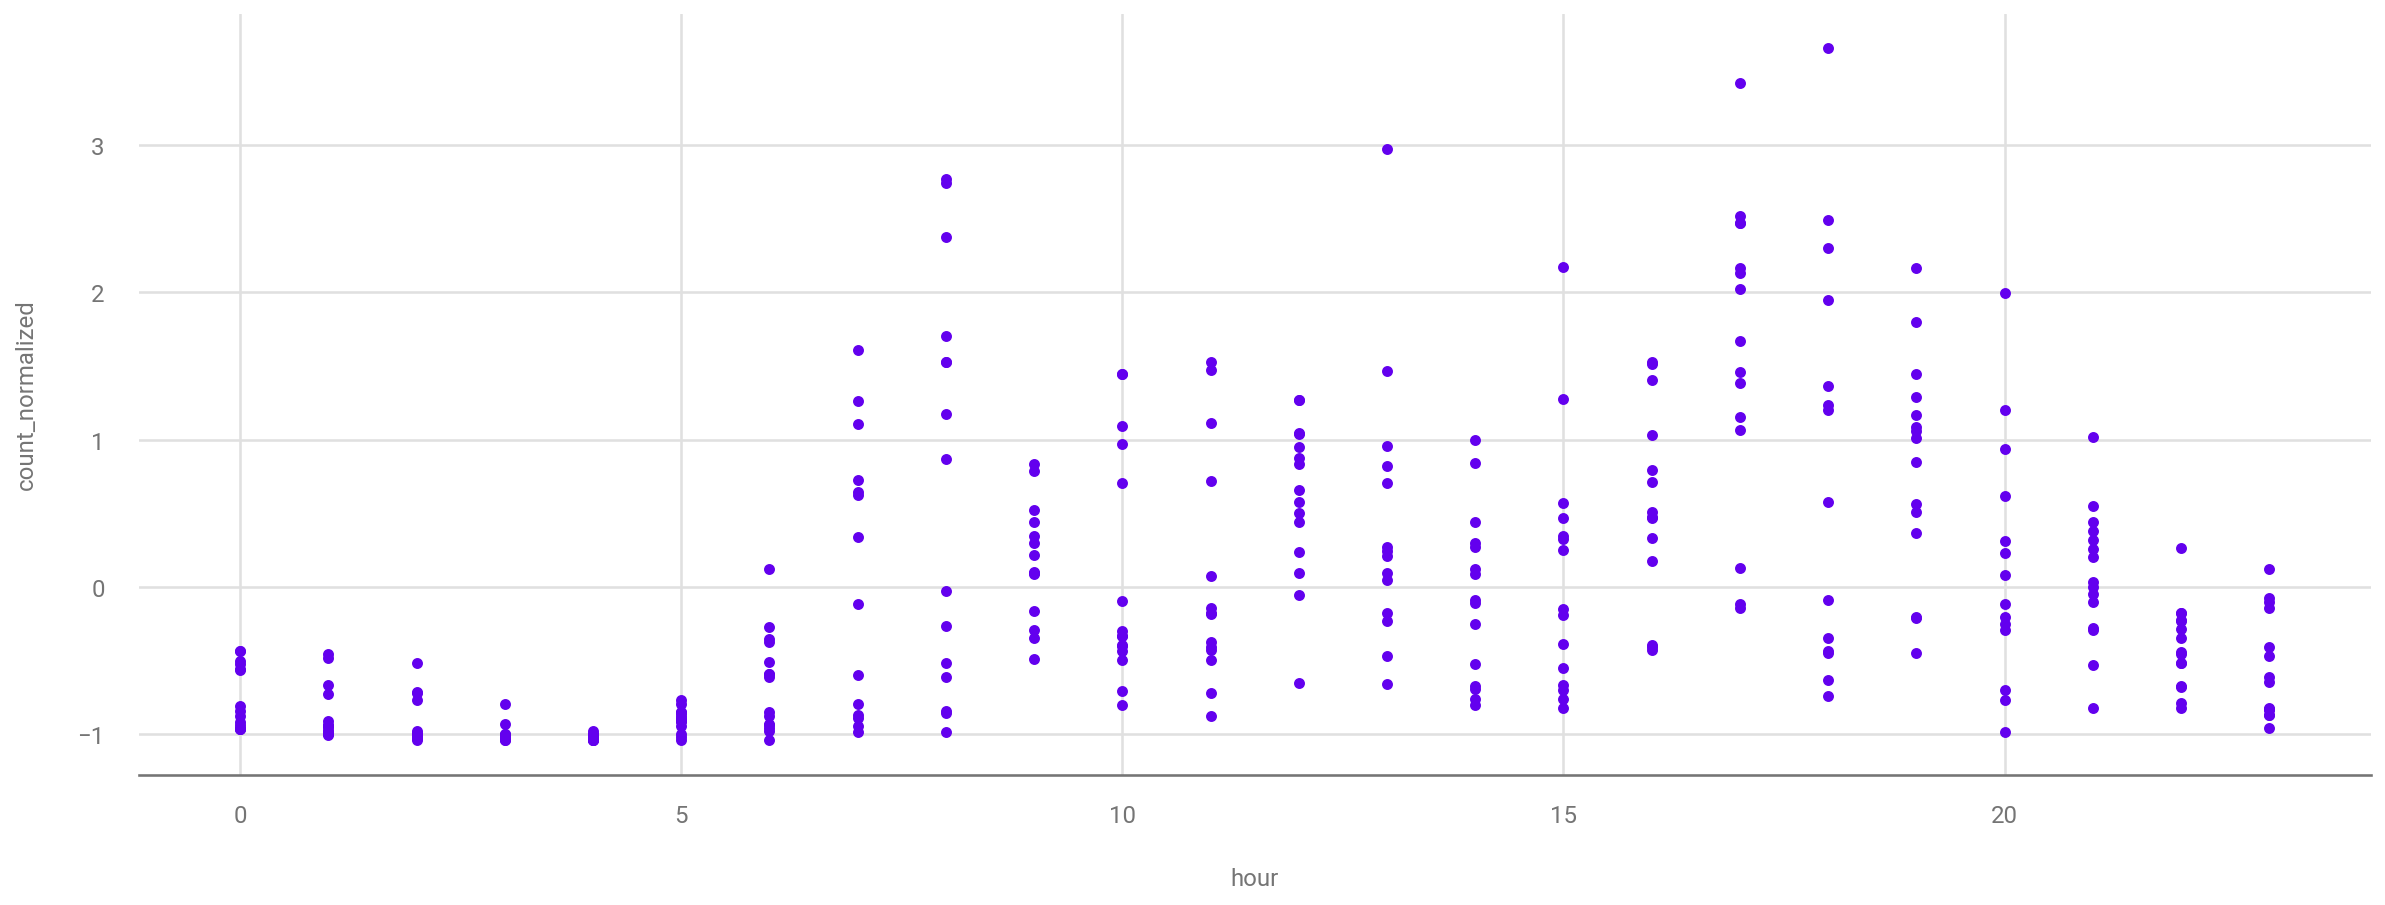

In [6]:
data = (
    pd.read_csv(
        "https://raw.githubusercontent.com"
        "/BayesianModelingandComputationInPython/BookCode_Edition1/main"
        "/data/bikes_hour.csv"
    )
    .sort_values(by="hour")
    .assign(
        count_normalized=lambda df: df["count"]
        .sub(df["count"].mean())
        .div(df["count"].std())
    )[::50]
)
_, ax = plt.subplots(figsize=(20, 7))
data.plot.scatter(x="hour", y="count_normalized", ax=ax);

In [7]:
num_knots = 6
knot_list = np.linspace(data["hour"].min(), data["hour"].max(), num_knots + 2)[1:-1]
knot_list

array([ 3.28571429,  6.57142857,  9.85714286, 13.14285714, 16.42857143,
       19.71428571])

Above,
boundaries are removed to ensure knots are defined within the data.
This depends on situation—such
as if bulk of data is away from the borders.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, τ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


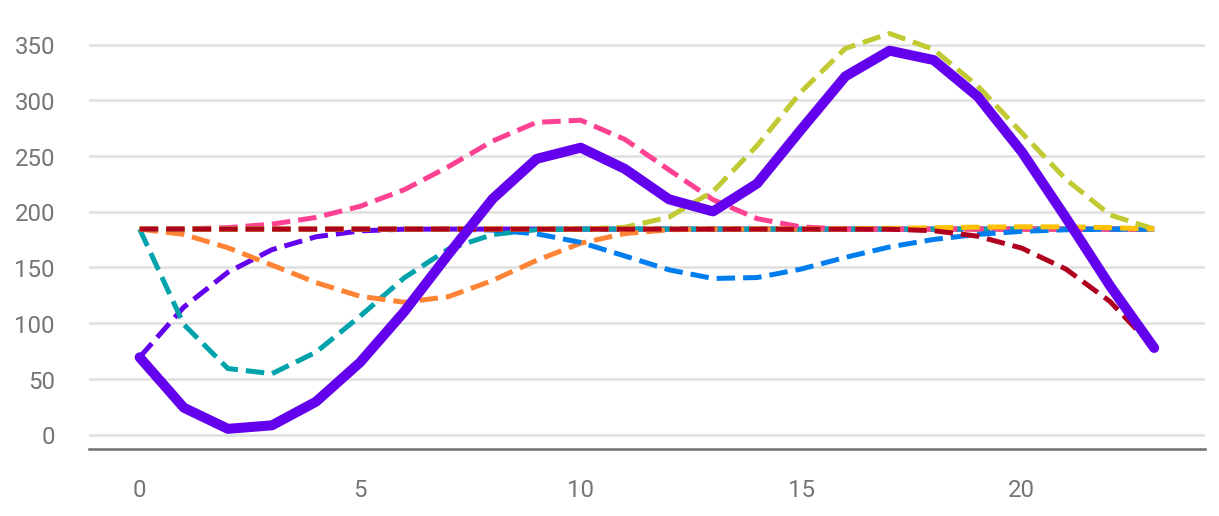

In [22]:
b = patsy.dmatrix(
    "bs(cnt, knots=knots, degree=3, include_intercept=True) - 1",
    {"cnt": data["hour"].to_numpy(), "knots": knot_list[1:-1]},
)

with pm.Model() as splines:
    τ = pm.HalfCauchy("τ", 1)
    β = pm.Normal("β", mu=0, sd=τ, shape=b.shape[1])
    μ = pm.Deterministic("μ", var=pm.math.dot(np.asarray(b), β))
    σ = pm.HalfNormal("σ", sigma=1)
    c = pm.Normal("c", mu=μ, sd=σ, observed=data["count_normalized"].values)

    idata_s = pm.sample(1_000, return_inferencedata=True)

_, ax = plt.subplots(figsize=(10, 4))
posterior = idata_s["posterior"].stack(samples=["chain", "draw"])
x = data["hour"]
data_cnt_os = data["count"].std()
data_cnt_om = data["count"].mean()
ax.plot(
    x,
    b * posterior["β"].mean("samples").to_numpy() * data_cnt_os + data_cnt_om,
    ls="--",
)
ax.plot(x, posterior["μ"].mean("samples") * data_cnt_os + data_cnt_om, lw=5);

/Users/pawlu/Library/Caches/pypoetry/virtualenvs/bayesian-modeling-computation-python-XD4SKI4--py3.9/lib/python3.9/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


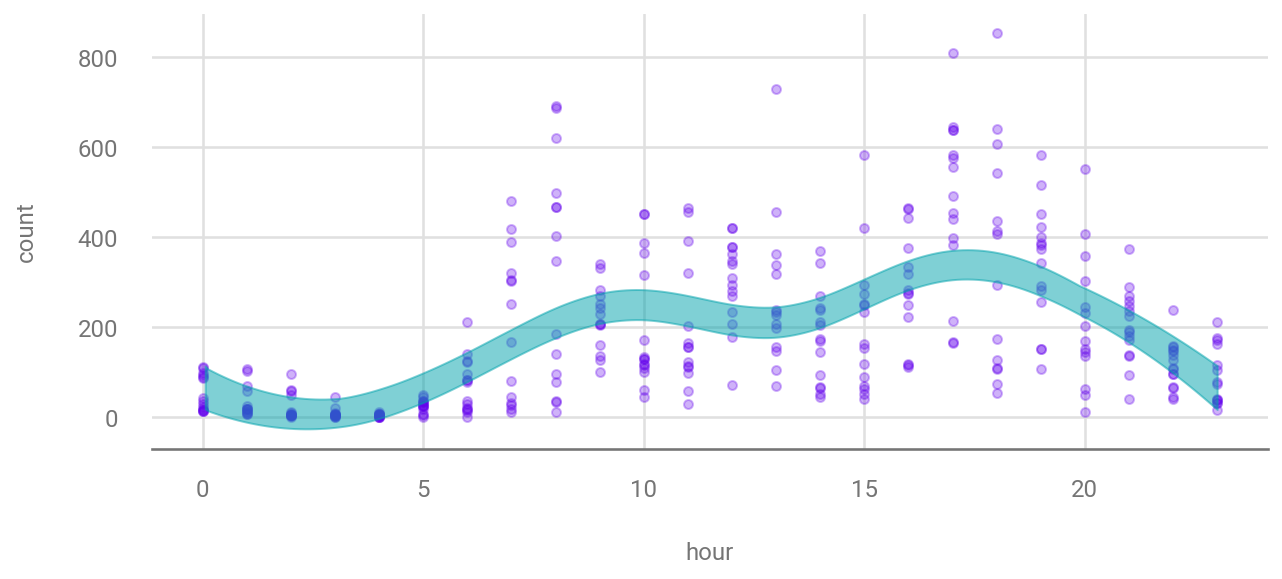

In [25]:
_, ax = plt.subplots(figsize=(10, 4))
data.plot.scatter(x="hour",y="count", alpha=0.3, ax=ax)
az.plot_hdi(x, posterior["μ"].T * data_cnt_os + data_cnt_om, ax=ax);

In this data,
hour 0 is equal to 24.
With Patsy,
instead of defining design matrix using `bs`,
use `cc`—a cubic spline that is circular-aware.

## Choosing knots and prior for splines

To choose the number and location of knots,
can use LOO to help pick best model.

In [27]:
Bs = []

num_knots = (3, 6, 9, 12, 18)
for nk in num_knots:
    knot_list = np.linspace(0, 24, nk + 2)[1:-1]
    B = patsy.dmatrix(
        "bs(cnt, knots=knots, degree=3, include_intercept=True) - 1",
        {"cnt": data.hour.values, "knots": knot_list},
    )
    Bs.append(B)

idatas = []
for B in Bs:
    with pm.Model() as splines:
        τ = pm.HalfCauchy("τ", 1)
        β = pm.Normal("β", mu=0, sd=τ, shape=B.shape[1])
        μ = pm.Deterministic("μ", pm.math.dot(np.asfortranarray(B), β))
        σ = pm.HalfNormal("σ", 1)
        c = pm.Normal("c", μ, σ, observed=data["count_normalized"].values)
        idata = pm.sample(1000, return_inferencedata=True)
        idatas.append(idata)

az.compare({f"m_{k}k": v for k, v in zip(num_knots, idatas)})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, τ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, τ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, τ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, τ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, τ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m_12k,0,-377.293680,13.885672,0.000000,8.839445e-01,17.896448,0.000000,False,log
m_18k,1,-379.743412,17.536635,2.449732,1.897141e-15,17.889491,1.564466,False,log
m_9k,2,-380.497640,11.429685,3.203961,0.000000e+00,18.123676,3.034181,False,log
m_6k,3,-389.553437,9.388151,12.259757,0.000000e+00,18.047364,5.712127,False,log
m_3k,4,-400.019352,7.000037,22.725673,1.160555e-01,17.998621,7.770323,False,log


Weight is 0.88 for highest ranked model,
0.12 for lowest ranked,
and 0 everywhere else.
Even when the in between models have better `loo` values,
they contribute little to `m_12k`—while
`m_3k` does.

Instead of uniformly,
knots can be placed based on quantiles.

In [32]:
num_knots = 6
knot_list = np.quantile(data["hour"], np.linspace(0, 1, num_knots))
knot_list

array([ 0.,  4.,  9., 14., 19., 23.])

### Regularizing prior for splines

Choosing too few knots can lead to underfitting,
too many overfitting.
Can choose a large number of knots with a regularizing prior.

The closer the consecutive $\beta$ coefficients are to each other,
the smoother the function.
Consecutive coefficients share similar domains—if
you drop two consecutive ones,
the sub region loses coverage.
We can choose a prior for $\beta$ coefficients in such a way
that $\beta_{i + 1}$ is correlated to $\beta$.

$$
\begin{aligned}
\begin{split}
\beta_i \sim& \mathcal{N}(0, 1) \\
\tau\sim& \mathcal{N}(0,1) \\
\beta \sim& \mathcal{N}(\beta_{i-1}, \tau) 
\end{split}\end{aligned}
$$

Equivalently,
we can write

$$
\begin{aligned}
\begin{split}
\tau\sim& \mathcal{N}(0, 1) \\ff
\beta \sim& \mathcal{G}RW(\beta, \tau) 
\end{split}\end{aligned}
$$

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, τ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, τ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.


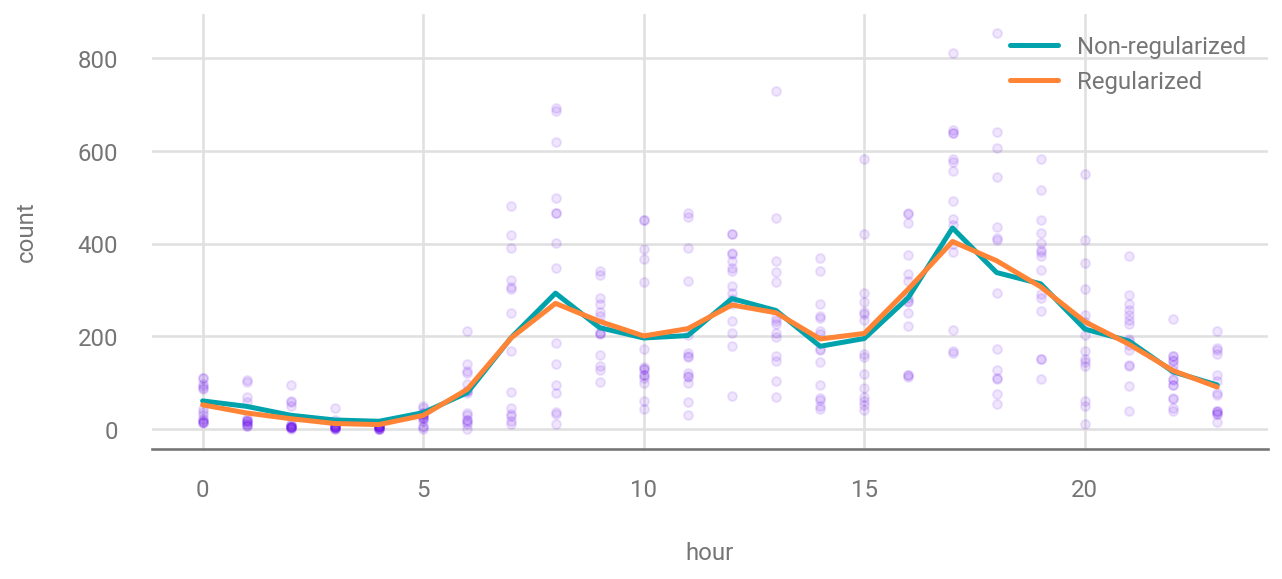

In [48]:
knot_list = np.arange(1, 23)

B = patsy.dmatrix(
    "bs(cnt, knots=knots, degree=3, include_intercept=True) - 1",
    {"cnt": data.hour.values, "knots": knot_list},
)

# Not smoothed
with pm.Model() as wiggly:
    τ = pm.HalfCauchy("τ", 1)
    β = pm.Normal("β", mu=0, sd=τ, shape=B.shape[1])
    μ = pm.Deterministic("μ", pm.math.dot(np.asfortranarray(B), β))
    σ = pm.HalfNormal("σ", 1)
    c = pm.Normal("c", μ, σ, observed=data["count_normalized"].values)
    trace_wiggly = pm.sample(1_000, return_inferencedata=False)
    idata_wiggly = az.from_pymc3(
        trace=trace_wiggly,
        posterior_predictive=pm.sample_posterior_predictive(trace_wiggly),
    )

# Smoothed
with pm.Model() as splines_rw:
    τ = pm.HalfCauchy("τ", beta=1)
    β = pm.GaussianRandomWalk("β", mu=0, sigma=τ, shape=B.shape[1])
    μ = pm.Deterministic("μ", var=pm.math.dot(np.asarray(B), β))
    σ = pm.HalfNormal("σ", sigma=1)
    c = pm.Normal("c", mu=μ, sigma=σ, observed=data["count_normalized"].to_numpy())
    trace_splines_rw = pm.sample(1_000, return_inferencedata=False)
    posterior_predictive_splines_rw = pm.sample_posterior_predictive(trace_splines_rw)
    idata_splines_rw = az.from_pymc3(
        trace=trace_splines_rw,
        posterior_predictive=posterior_predictive_splines_rw,
    )

_, ax = plt.subplots(figsize=(10, 4))
data.plot.scatter(x="hour", y="count", ax=ax, alpha=0.1)
ax.plot(
    data["hour"],
    ((idata_wiggly.posterior["μ"] * data_cnt_os) + data_cnt_om).mean(
        dim=["chain", "draw"]
    ),
    color="C1",
    label="Non-regularized",
)
ax.plot(
    data["hour"],
    ((idata_splines_rw.posterior["μ"] * data_cnt_os) + data_cnt_om).mean(
        dim=["chain", "draw"]
    ),
    color="C2",
    label="Regularized",
)
ax.legend();

## Modeling CO₂ uptake with splines

In [3]:
plants_CO2 = pd.read_csv(
    "https://raw.githubusercontent.com"
    "/BayesianModelingandComputationInPython/BookCode_Edition1/main"
    "/data/CO2_uptake.csv"
)
plant_names = plants_CO2["Plant"].unique()
CO2_concs = plants_CO2["conc"].to_numpy()
CO2_conc = CO2_concs[:7]
uptake = plants_CO2["uptake"].to_numpy()
plants_CO2.head()

,Plant,Type,Treatment,conc,uptake
0,Qn1,Quebec,nonchilled,95,16.0
1,Qn1,Quebec,nonchilled,175,30.4
2,Qn1,Quebec,nonchilled,250,34.8
3,Qn1,Quebec,nonchilled,350,37.2
4,Qn1,Quebec,nonchilled,500,35.3


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, τ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 34 seconds.
/Users/pawlu/Library/Caches/pypoetry/virtualenvs/bayesian-modeling-computation-python-XD4SKI4--py3.9/lib/python3.9/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/pawlu/Library/Caches/pypoetry/virtualenvs/bayesian-modeling-computation-python-XD4SKI4--py3.9/lib/python3.9/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/pawlu/Library/Caches/pypoetry/virtualenvs/bayesian-modeling-computation-python-

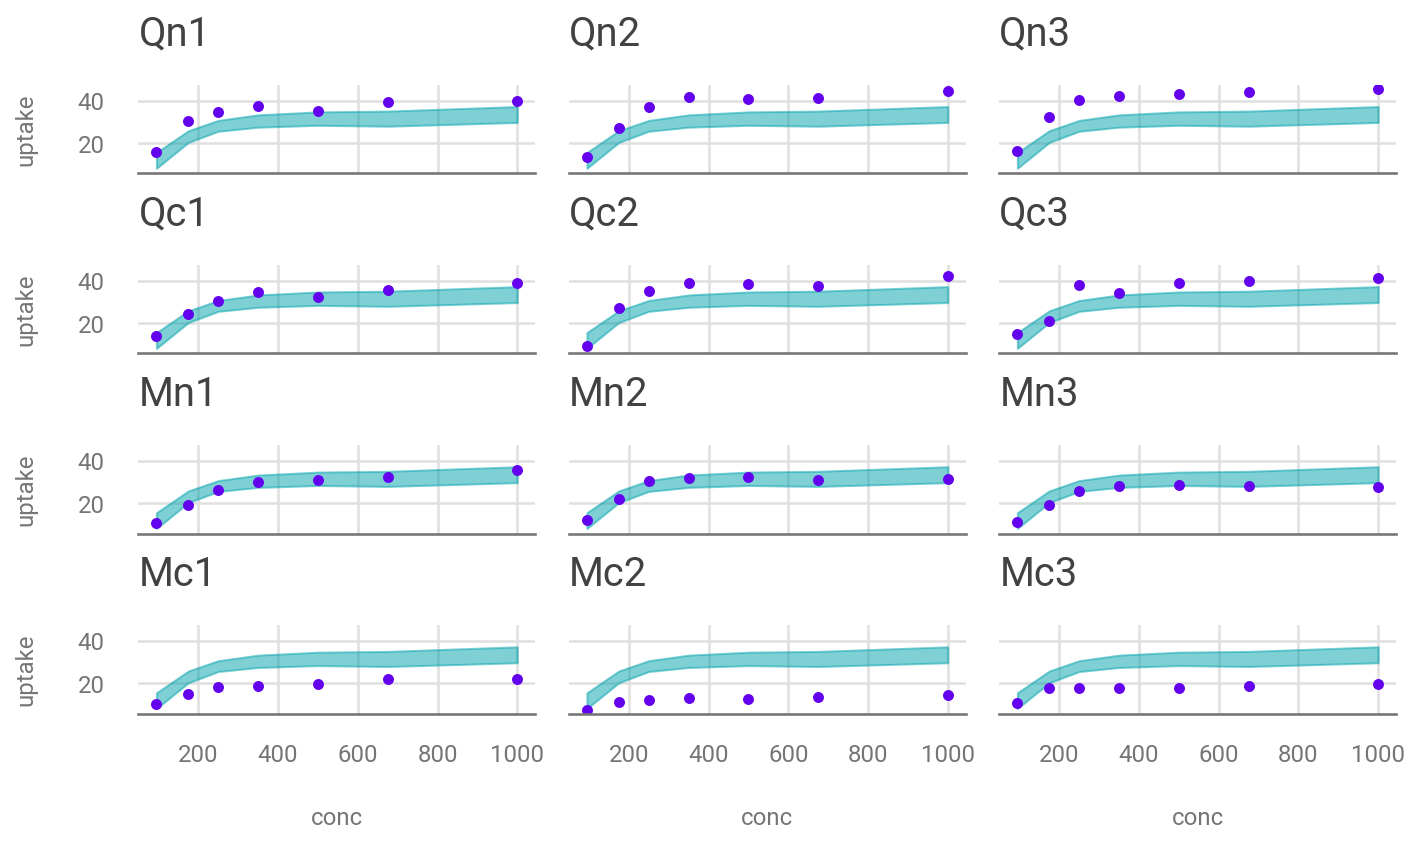

In [26]:
num_knots = 2
knot_list = np.linspace(CO2_conc[0], CO2_conc[-1], num_knots + 2)[1:-1]
Bg = patsy.dmatrix(
    "bs(conc, knots=knots, degree=3, include_intercept=True) - 1",
    {"conc": CO2_concs, "knots": knot_list},
)

with pm.Model(coords={"idx": plants_CO2.index}) as sp_global:
    τ = pm.HalfCauchy("τ", beta=1)
    β = pm.Normal("β", mu=0, sigma=τ, shape=Bg.shape[1])
    μg = pm.Deterministic("μg", pm.math.dot(np.asarray(Bg), β), dims="idx")
    σ = pm.HalfNormal("σ", sigma=1)
    up = pm.Normal("up", mu=μg, sigma=σ, observed=uptake, dims="idx")
    idata_sp_global = pm.sample(2_000, return_inferencedata=True)

_, axes = plt.subplots(4, 3, figsize=(10, 6), sharey=True, sharex=True)
msg = idata_sp_global["posterior"].stack(draws=["chain", "draw"])["μg"]
for plant_name, ax in zip(plant_names, axes.ravel()):
    plant_idx = plants_CO2.loc[lambda df: df["Plant"] == plant_name].index
    az.plot_hdi(
        plants_CO2.loc[plant_idx, "conc"],
        msg.sel(idx=plant_idx).values.T,
        smooth=False,
        ax=ax,
    )
    plants_CO2.loc[plant_idx].plot.scatter(x="conc", y="uptake", ax=ax)
    ax.set_title(plant_name)
plt.tight_layout();

Model is only providing good fit for some plants.
Try different responce per plant.

In [124]:
Bi = patsy.dmatrix(
    "bs(conc, knots=knots, degree=3, include_intercept=True) - 1",
    {"conc": CO2_conc, "knots": knot_list},
)
index = range(12)
with pm.Model(
    coords={
        "CO2_conc": CO2_conc,
        "knots": range(int(3 * num_knots)),
        "groups": plants_CO2["Plant"].unique(),
    }
) as sp_individual:
    τ = pm.HalfCauchy("τ", 1)
    β = pm.Normal("β", mu=0, sigma=τ, dims=("knots", "groups"))
    μi = pm.Deterministic(
        "μi", pm.math.dot(np.asarray(Bi), β), dims=("CO2_conc", "groups")
    )
    σ = pm.HalfNormal("σ", 1)
    up = pm.Normal("up", μi.T.ravel(), σ, observed=uptake)
    idata_sp_individual = pm.sample(2_000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β, τ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 34 seconds.
The number of effective samples is smaller than 25% for some parameters.


/Users/pawlu/Library/Caches/pypoetry/virtualenvs/bayesian-modeling-computation-python-XD4SKI4--py3.9/lib/python3.9/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/pawlu/Library/Caches/pypoetry/virtualenvs/bayesian-modeling-computation-python-XD4SKI4--py3.9/lib/python3.9/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/pawlu/Library/Caches/pypoetry/virtualenvs/bayesian-modeling-computation-python-XD4SKI4--py3.9/lib/python3.9/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently inte

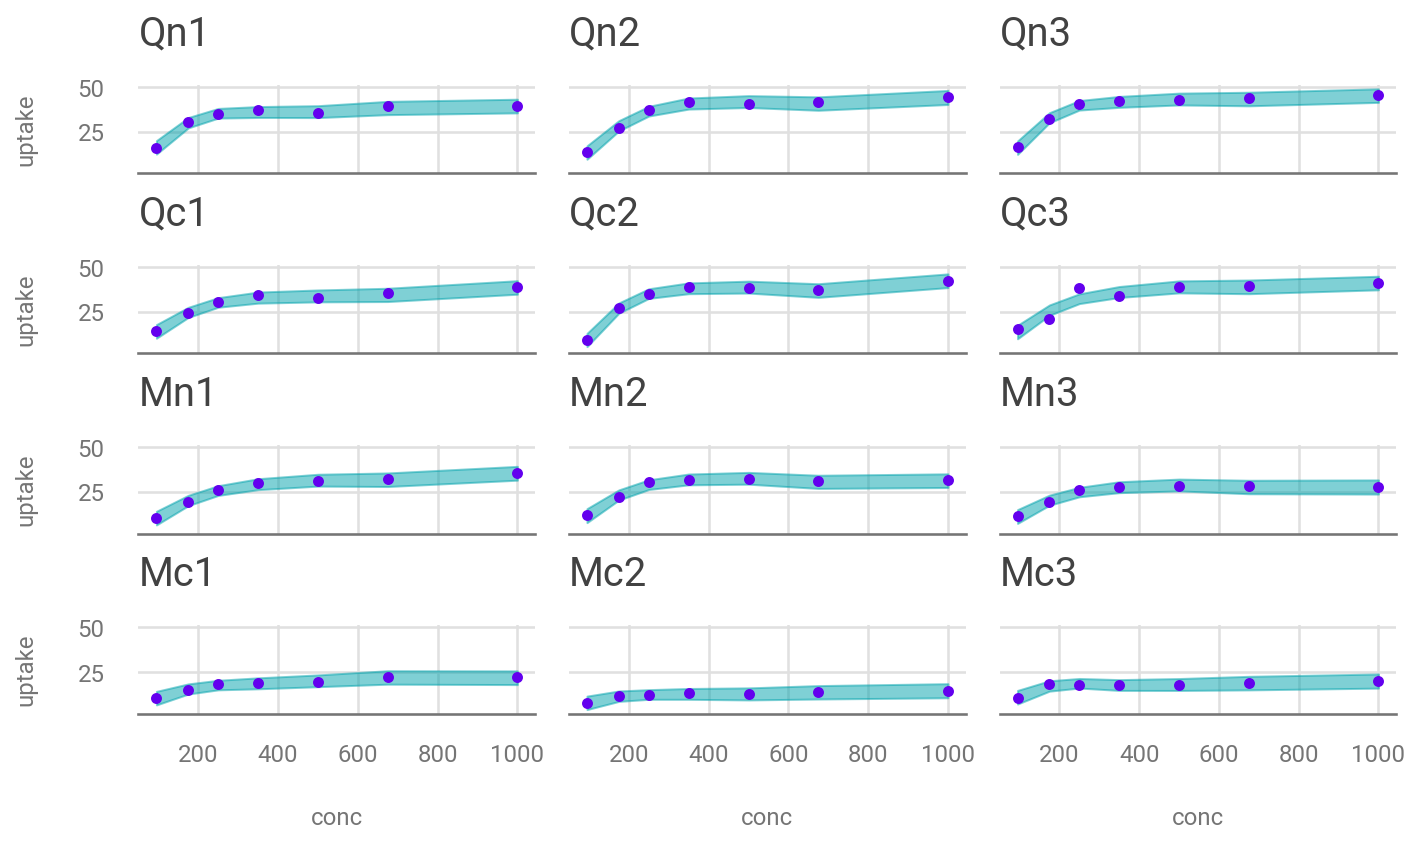

In [125]:
_, axes = plt.subplots(4, 3, figsize=(10, 6), sharey=True, sharex=True)
msi = idata_sp_individual["posterior"].stack(draws=["chain", "draw"])["μi"]
for plant_name, ax in zip(plant_names, axes.ravel()):
    plant_idx = plants_CO2.loc[lambda df: df["Plant"] == plant_name].index
    az.plot_hdi(
        plants_CO2.loc[plant_idx, "conc"],
        msi.sel(groups=plant_name).values.T,
        smooth=False,
        ax=ax,
    )
    plants_CO2.loc[plant_idx].plot.scatter(x="conc", y="uptake", ax=ax)
    ax.set_title(plant_name)
plt.tight_layout();

Can also mix both previous models.
Can be used to estiamte a global trends
along with individual fits.

In [127]:
with pm.Model(
    coords={
        "CO2_conc": CO2_conc,
        "knots": range(int(3 * num_knots)),
        "groups": plants_CO2["Plant"].unique(),
        "idx": plants_CO2.index,
    }
) as sp_mix:
    τ = pm.HalfCauchy("τ", beta=1)
    βg = pm.Normal("βg", mu=0, sigma=τ, shape=Bg.shape[1])
    μg = pm.Deterministic("μg", pm.math.dot(np.asarray(Bg), βg), dims="idx")
    βi = pm.Normal("βi", mu=0, sigma=τ, dims=("knots", "groups"))
    μi = pm.Deterministic(
        "μi", var=pm.math.dot(np.asarray(Bi), βi), dims=("CO2_conc", "groups")
    )
    σ = pm.HalfNormal("σ", 1)
    up = pm.Normal("up", μg + μi.T.ravel(), σ, observed=uptake)
    idata_sp_mix = pm.sample(2_000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, βi, βg, τ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 48 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


/Users/pawlu/Library/Caches/pypoetry/virtualenvs/bayesian-modeling-computation-python-XD4SKI4--py3.9/lib/python3.9/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/pawlu/Library/Caches/pypoetry/virtualenvs/bayesian-modeling-computation-python-XD4SKI4--py3.9/lib/python3.9/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/pawlu/Library/Caches/pypoetry/virtualenvs/bayesian-modeling-computation-python-XD4SKI4--py3.9/lib/python3.9/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently inte

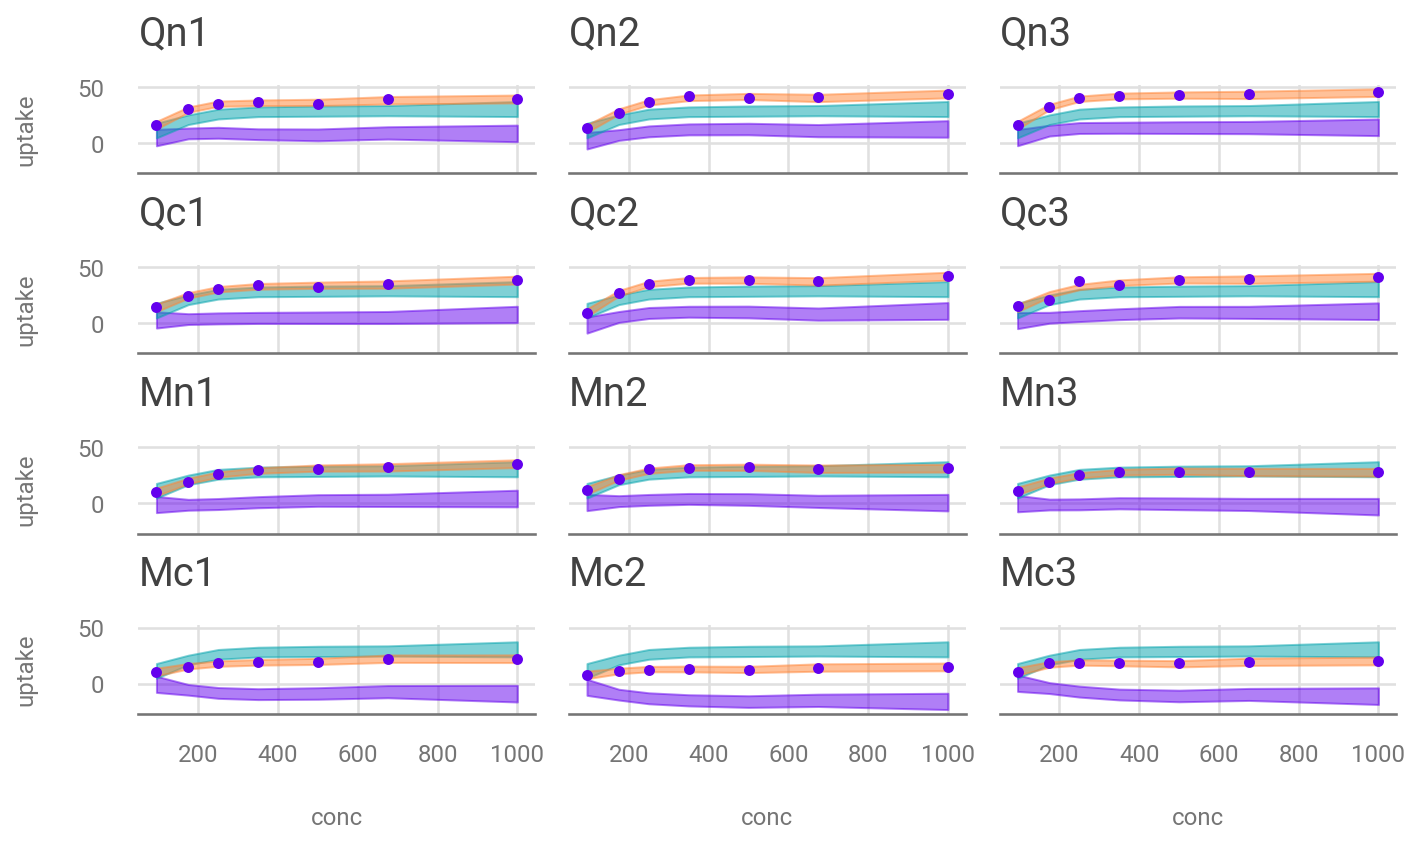

In [132]:
_, axes = plt.subplots(4, 3, figsize=(10, 6), sharey=True, sharex=True)
msi = idata_sp_mix["posterior"].stack(draws=["chain", "draw"])["μi"]
msg = idata_sp_mix["posterior"].stack(draws=["chain", "draw"])["μg"]
for plant_name, ax in zip(plant_names, axes.ravel()):
    plant_idx = plants_CO2.loc[lambda df: df["Plant"] == plant_name].index
    x = plants_CO2.loc[plant_idx, "conc"]
    group_msi = msi.sel(groups=plant_name).values.T
    az.plot_hdi(x, group_msi, smooth=False, ax=ax, color="C0")
    group_msg = msg.sel(idx=plant_idx).values.T
    az.plot_hdi(x, group_msg, smooth=False, ax=ax, color="C1")
    az.plot_hdi(
        x,
        group_msi + group_msg,
        smooth=False,
        ax=ax,
        color="C2",
    )
    plants_CO2.loc[plant_idx].plot.scatter(x="conc", y="uptake", ax=ax)
    ax.set_title(plant_name)
plt.tight_layout();

Individual fit (orange)
can be split into global trend (teal)
and deviation of the trend (purple).

In [134]:
cmp = az.compare(
    {
        "sp_global": idata_sp_global,
        "sp_individual": idata_sp_individual,
        "sp_mix": idata_sp_mix,
    }
)
cmp

/Users/pawlu/Library/Caches/pypoetry/virtualenvs/bayesian-modeling-computation-python-XD4SKI4--py3.9/lib/python3.9/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/pawlu/Library/Caches/pypoetry/virtualenvs/bayesian-modeling-computation-python-XD4SKI4--py3.9/lib/python3.9/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likel

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
sp_mix,0,-214.334372,55.415326,0.000000,0.961162,13.004895,0.000000,True,log
sp_individual,1,-227.416115,60.937434,13.081744,0.000000,11.890542,1.831162,True,log
sp_global,2,-307.386913,8.952173,93.052541,0.038838,8.996441,16.175659,False,log


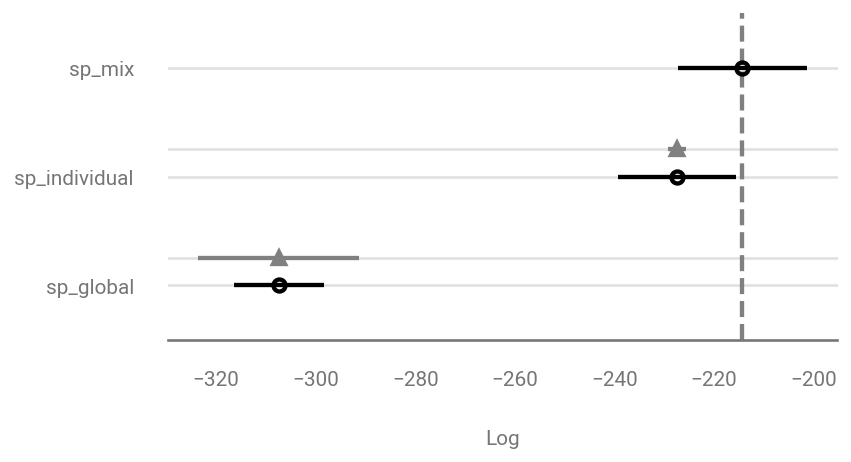

In [136]:
az.plot_compare(cmp, insample_dev=False);

Mixed model has best LOO.
Though errors for mix and individual overlap.
`sp_mix` and `sp_individual` are penalized harder than `sp_global`—the
distance between the empty and black circle is shorter for `sp_global`.
There is also warnings that estimated shape parameter of Pareto distribution is greater than 0.7.